In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch as th
from torch import nn, optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import copy
import time
import seaborn as sns
import pickle as pkl
from operator import itemgetter

In [2]:
metro = pd.read_csv("data/dataset_train.csv")
metro["timestamp"] = pd.to_datetime(metro["timestamp"],dayfirst=True)
metro["timestamp_day"] = metro.timestamp - np.timedelta64(2,"h")-np.timedelta64(1,"s")

In [3]:
air_leak1_dates = {"start": pd.to_datetime("28-02-2022 21:53:00",
                                           dayfirst=True)-pd.offsets.DateOffset(hours=2,seconds=1),
                   "end":pd.to_datetime("01-03-2022 02:00:00",
                                        dayfirst=True)- pd.offsets.DateOffset(hours=2,seconds=1)}
air_leak2_dates = {"start": pd.to_datetime("23-03-2022 14:54:00",
                                           dayfirst=True)-pd.offsets.DateOffset(hours=2,seconds=1),
                   "end":pd.to_datetime("23-03-2022 15:24:00",
                                        dayfirst=True)-pd.offsets.DateOffset(hours=2,seconds=1)}
oil_leak_dates = {"start": pd.to_datetime("30-05-2022 12:00:00",
                                          dayfirst=True)-pd.offsets.DateOffset(hours=2,seconds=1),
                  "end":pd.to_datetime("02-06-2022 06:18:00",
                                       dayfirst=True)-pd.offsets.DateOffset(hours=2,seconds=1)}

In [4]:
air_leak1 = metro.loc[(metro.timestamp_day >= air_leak1_dates["start"]) &
                      (metro.timestamp_day < air_leak1_dates["end"]),:]
air_leak2 = metro.loc[(metro.timestamp_day >= air_leak2_dates["start"]) &
                      (metro.timestamp_day < air_leak2_dates["end"]),:]
oil_leak = metro.loc[(metro.timestamp_day >= oil_leak_dates["start"]) &
                     (metro.timestamp_day < oil_leak_dates["end"]),:]

In [10]:
def test_and_train_val_dates():
    init_train_s = metro.timestamp_day[0]
    init_train_e = metro.timestamp_day[0] + pd.offsets.DateOffset(months=1) - pd.offsets.DateOffset(days=2)
    init_val_s = metro.timestamp_day[0] + pd.offsets.DateOffset(months=1) - pd.offsets.DateOffset(days=2)
    init_val_e = metro.timestamp_day[0] + pd.offsets.DateOffset(months=1)
    init_test_s = init_val_e
    init_test_e = init_test_s + pd.offsets.DateOffset(weeks=1)

    train_dates = [[init_train_s,init_train_e]]
    test_dates = [[init_test_s,init_test_e]]
    val_dates = [[init_val_s, init_val_e]]

    last_date = metro.timestamp_day.iloc[-1]
    prev_test_end = init_test_e
    while prev_test_end < last_date:
        new_test_end = prev_test_end + pd.offsets.DateOffset(weeks=1)
        new_train_start = prev_test_end - pd.offsets.DateOffset(months=1)
        new_val_start = prev_test_end - pd.offsets.DateOffset(days=2)
        train_dates.append([new_train_start,new_val_start])
        val_dates.append([new_val_start, prev_test_end])
        test_dates.append([prev_test_end,new_test_end])
        prev_test_end = new_test_end
    return train_dates, val_dates, test_dates

In [11]:
train_dates, val_dates, test_dates = test_and_train_val_dates()

In [15]:
metro.iloc[1378:1477,:]

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,COMP,...,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,gpsLong,gpsLat,gpsSpeed,gpsQuality,timestamp_day
1378,2022-01-01 06:22:58,-0.012,8.030,8.028,-0.028,1.572,58.575,18.862750,0.0075,0,...,0,0,0,0,0,-8.65944,41.2123,0,1,2022-01-01 04:22:57
1379,2022-01-01 06:22:59,0.066,8.030,0.140,-0.028,1.572,58.525,19.367313,4.7225,0,...,0,0,0,0,0,-8.65944,41.2123,0,1,2022-01-01 04:22:58
1380,2022-01-01 06:23:00,1.000,8.028,-0.028,-0.028,1.572,58.525,19.133719,4.8575,0,...,0,0,0,0,0,-8.65944,41.2123,0,1,2022-01-01 04:22:59
1381,2022-01-01 06:23:01,3.660,8.026,-0.028,-0.026,1.574,58.475,19.012250,4.7975,0,...,0,0,0,0,0,-8.65944,41.2123,0,1,2022-01-01 04:23:00
1382,2022-01-01 06:23:02,4.508,8.026,-0.030,-0.026,1.574,58.500,19.012250,4.9975,0,...,0,0,0,0,0,-8.65944,41.2123,0,1,2022-01-01 04:23:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,2022-01-01 06:24:32,10.448,9.976,-0.018,-0.018,1.572,63.825,31.140438,6.0500,0,...,0,0,0,0,0,-8.65946,41.2123,0,1,2022-01-01 04:24:31
1473,2022-01-01 06:24:33,10.484,10.016,-0.016,-0.020,1.574,63.950,30.953563,6.1675,0,...,0,0,0,0,0,-8.65946,41.2123,0,1,2022-01-01 04:24:32
1474,2022-01-01 06:24:34,10.504,10.034,-0.018,-0.018,1.570,63.975,31.018969,6.1400,0,...,0,0,0,0,0,-8.65946,41.2123,0,1,2022-01-01 04:24:33
1475,2022-01-01 06:24:35,10.522,10.054,-0.016,-0.018,1.572,64.125,31.056344,6.0150,0,...,0,0,0,0,0,-8.65946,41.2123,0,1,2022-01-01 04:24:34


In [5]:
list((t:=metro.COMP.diff().eq(0))[t==False].index[1:])

[1378,
 1477,
 2865,
 2969,
 4411,
 4532,
 5124,
 5245,
 6830,
 6933,
 8049,
 8155,
 9824,
 9929,
 11192,
 11315,
 11758,
 11881,
 12411,
 12529,
 13331,
 13434,
 14022,
 14144,
 15370,
 15476,
 17204,
 17309,
 18673,
 18774,
 20449,
 20559,
 21090,
 21204,
 21725,
 21837,
 22803,
 22927,
 23488,
 23599,
 25252,
 25358,
 26949,
 27055,
 29217,
 29324,
 29817,
 29937,
 30537,
 30649,
 31341,
 31444,
 32166,
 32283,
 33616,
 33722,
 35441,
 35545,
 37310,
 37409,
 38756,
 38885,
 39452,
 39568,
 40175,
 40300,
 41146,
 41269,
 42252,
 42358,
 43965,
 44073,
 45468,
 45570,
 47559,
 47659,
 48124,
 48231,
 48869,
 49001,
 49896,
 50015,
 50541,
 50650,
 52236,
 52337,
 53935,
 54041,
 55709,
 55814,
 57422,
 57784,
 60065,
 60546,
 62428,
 62530,
 63757,
 63862,
 64985,
 65113,
 65707,
 65822,
 66501,
 66613,
 67497,
 67616,
 68894,
 68999,
 70743,
 70846,
 72808,
 72908,
 74114,
 74229,
 74760,
 74882,
 75435,
 75538,
 76430,
 76542,
 77153,
 77252,
 78797,
 78905,
 80591,
 80696,
 82730

In [16]:
def generate_cycles(df):
    comp_change = list((t:=metro.COMP.diff().eq(0))[t==False].index[1:]) # if all changes to separate
    #filling up and spending
    #comp_change = list((t:=df.COMP.diff().eq(-1))[t==True].index)
    return [[comp_change[i],comp_change[i+1]] for i in range(len(comp_change)-1)]

In [17]:
all_cycles = generate_cycles(metro)

In [22]:
all_cycles_comp0 = [cycle for i, cycle in enumerate(all_cycles) if i%2 == 0]
all_cycles_comp1 = [cycle for i, cycle in enumerate(all_cycles) if i%2 == 1]

In [23]:
comp0_cycle_lengths = list(map(lambda x: (x[1] - x[0]), all_cycles_comp0))
comp1_cycle_lengths = list(map(lambda x: (x[1] - x[0]), all_cycles_comp1))

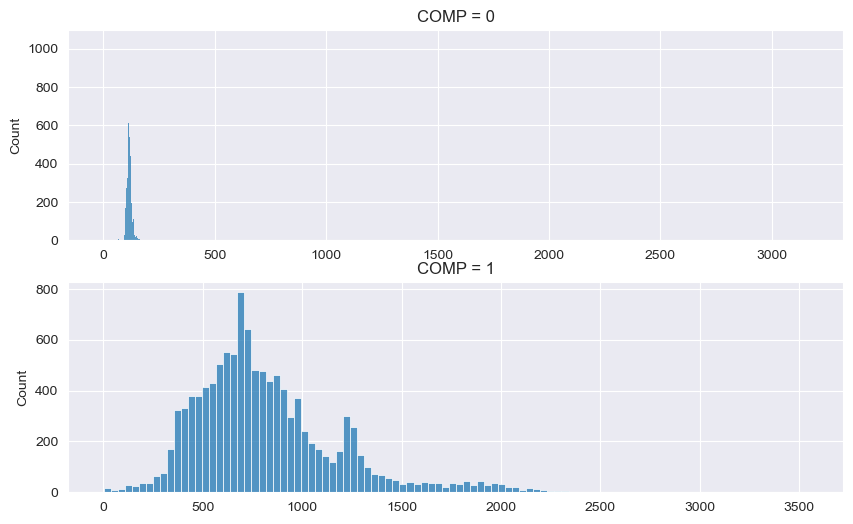

In [26]:
fig, axes = plt.subplots(2,1, figsize=(10,6))

sns.histplot([l for l in comp0_cycle_lengths if l<10000], ax = axes[0])
axes[0].set_title("COMP = 0")

sns.histplot(comp1_cycle_lengths, ax = axes[1])
axes[1].set_title("COMP = 1")

plt.show()

In [27]:
sorted(comp1_cycle_lengths,reverse=True)

[3545,
 3294,
 3284,
 2752,
 2719,
 2656,
 2653,
 2635,
 2622,
 2505,
 2454,
 2423,
 2411,
 2388,
 2375,
 2361,
 2338,
 2332,
 2322,
 2322,
 2311,
 2293,
 2293,
 2281,
 2281,
 2271,
 2269,
 2264,
 2258,
 2257,
 2246,
 2229,
 2228,
 2221,
 2216,
 2214,
 2210,
 2205,
 2201,
 2200,
 2196,
 2194,
 2194,
 2192,
 2187,
 2187,
 2185,
 2178,
 2177,
 2173,
 2170,
 2169,
 2164,
 2163,
 2162,
 2162,
 2161,
 2159,
 2158,
 2153,
 2152,
 2152,
 2149,
 2145,
 2142,
 2137,
 2136,
 2135,
 2129,
 2123,
 2119,
 2119,
 2117,
 2110,
 2107,
 2102,
 2100,
 2095,
 2092,
 2089,
 2088,
 2087,
 2085,
 2081,
 2079,
 2077,
 2077,
 2076,
 2073,
 2068,
 2066,
 2064,
 2063,
 2062,
 2062,
 2059,
 2059,
 2057,
 2055,
 2054,
 2053,
 2051,
 2050,
 2048,
 2046,
 2042,
 2041,
 2041,
 2038,
 2036,
 2034,
 2034,
 2032,
 2030,
 2027,
 2025,
 2024,
 2024,
 2023,
 2022,
 2020,
 2018,
 2017,
 2016,
 2013,
 2012,
 2012,
 2011,
 2008,
 2007,
 2005,
 2005,
 2004,
 2003,
 2002,
 2000,
 1999,
 1999,
 1998,
 1997,
 1997,
 1997,
 1996,